In [26]:
import numpy as np
np.random.seed(seed=1)
N = 200
K = 3
T = np.zeros((N,3), dtype=np.uint8)
X = np.zeros((N,2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])
Sig = np.array([[.7, .7], [.8, .3],[.3, .8]])
Pi = np.array([0.4, 0.8, 1])
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]

In [27]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

np.savez('class_data.npz', X_train = X_train, T_train=T_train,
         X_test = X_test, T_test = T_test, 
         X_range0 = X_range0, X_range1 = X_range1)

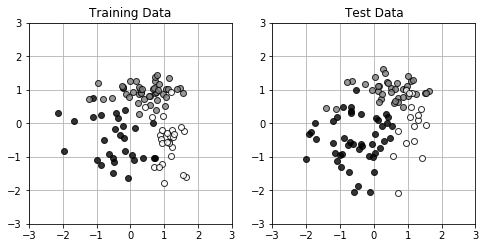

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                linestyle = 'none',
                marker='o', markeredgecolor='black',
                color=c[i], alpha=0.8)
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [29]:
def Sigmoid(x):
    y = 1 / (1+ np.exp(-x))
    return y

def FNN(wv, M, K, x):
    N, D = x.shape
    w = wv[:M*(D+1)]
    w = w.reshape(M, (D+1))
    v = wv[M*(D+1):]
    v = v.reshape((K, M+1))
    b = np.zeros((N, M+1))
    z = np.zeros((N, M+1))
    a = np.zeros((N,K))
    y = np.zeros((N,K))
    for n in range(N):
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])
            z[n, m] = Sigmoid(b[n, m])
        z[n, M] = 1
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b
    
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [30]:
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


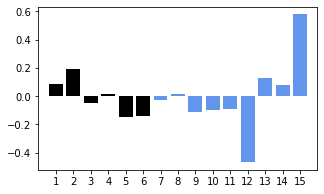

In [31]:
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 -mse1) / (2 * epsilon)
    return dwv

def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M*3 +1), wv[:M *3], align="center", color = 'black')
    plt.bar(range(M*3+1, N+1), wv[M*3:],
            align="center", color = 'cornflowerblue')
    plt.xticks(range(1, N+1))
    plt.xlim(0, N+1)
M = 2
K = 3
nWV = M*3 + K*(M+1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

In [32]:
import time

def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wvt = wvt -alpha*dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] =wvt
    return wvt, wv_hist, err_train, err_test



In [33]:
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M*3 + K*(M+1))
N_step = 1000
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() -startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:169.898 sec


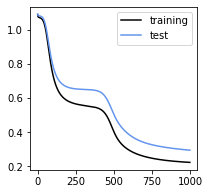

In [34]:
plt.figure(1, figsize =(3, 3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()
plt.show()

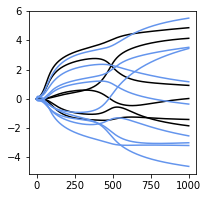

In [35]:
plt.figure(1, figsize = (3,3))
plt.plot(WV_hist[:, :M*3], 'black')
plt.plot(WV_hist[:, M*3:], 'cornflowerblue')
plt.show()

ValueError: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead

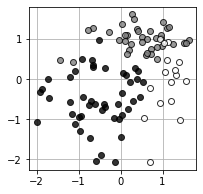

In [36]:
def show_FNN(wv, M, K):
    xn = 60
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4,4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                          colors = ['cornflowerblue', 'black'])
        cont.clabel(fmt = '%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.figure(1, figsize=(3,3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


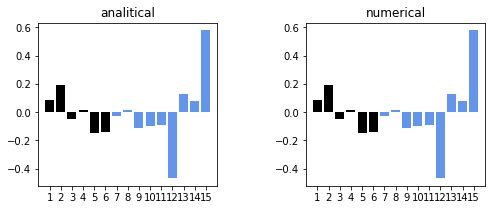

In [15]:
def dCE_FNN(wv, M, K, x ,t):
    N, D = x.shape
    w = wv[:M * (D+1)]
    w = w.reshape(M, (D+1))
    v = wv[M*(D+1):]
    v = v.reshape((K, M+1))
    y, a, z, b = FNN(wv, M, K, x)
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D+1))
    dv = np.zeros((K, M+1))
    delta1 = np.zeros(M)
    delta2 = np.zeros(K)
    for n in range(N):
        for k in range(K):
            delta2[k] = (y[n, k] - t[n,k])
        for j in range(M):
            delta1[j] = z[n,j] * (1 - z[n, j])*np.dot(v[:, j], delta2)
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        for j in range(M):
            dw[j,:] = dw[j, :] +delta1[j] * np.r_[x[n, :], 1] / N
            
    dwv = np.c_[dw.reshape((1, M*(D+1))), \
               dv.reshape((1, K*(M+1)))]
    dwv = dwv.reshape(-1)
    return dwv

def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M*3 +1), wv[:M*3],
          align="center", color= 'black')
    plt.bar(range(M*3+1, N+1), wv[M*3:],
           align="center", color='cornflowerblue')
    plt.xticks(range(1, N+1))
    plt.xlim(0, N+1)
    

M = 2
K = 3
N = 2
nWV = M*3 + K*(M+1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [16]:
import time
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n , alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wv = wv- alpha*dCE_FNN(wv, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M*3 + K*(M+1))
N_step = 1000
alpha = 1
WV, WV_hist, ERR_train, ERR_test = Fit_FNN(
WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:25.537 sec


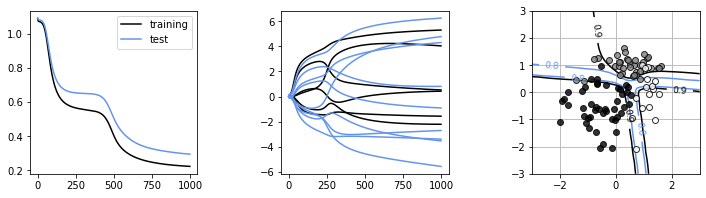

In [17]:
plt.figure(1, figsize=(12,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,3,1)
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()

plt.subplot(1,3,2)
plt.plot(WV_hist[:, :M*3], 'black')
plt.plot(WV_hist[:, M*3:], 'cornflowerblue')
plt.subplot(1, 3,3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

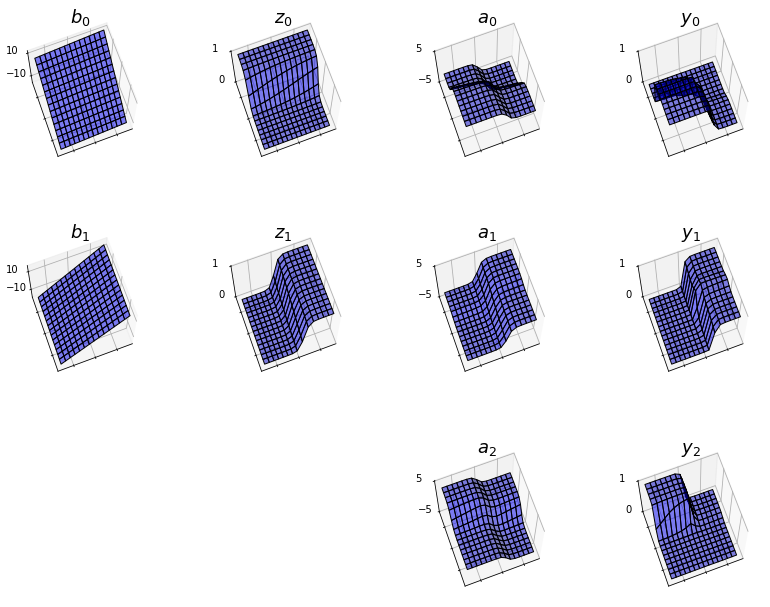

In [18]:
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color= 'blue', edgecolor = 'black',
                    rstride = 1, cstride = 1, alpha =0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize=18)
    
M = 2
K = 3
xn = 15
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'A'), np.reshape(xx1, xn*xn,'A')]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize = (12, 9))
plt.subplots_adjust(left=0.075, bottom = 0.05, right = 0.95,
                   top = 0.95, wspace = 0.4, hspace = 0.4)

for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection = '3d')
    show_activation3d(ax, b[:,m],[-10,10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection = '3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))

for k in range(K):
    ax = fig.add_subplot(3, 4, 3+ k * 4, projection = '3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4+k*4, projection='3d')
    show_activation3d(ax, y[:,k],[0,1], '$y_{0:d}$'.format(k))
    
plt.show()

In [20]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation

outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                linestyle = 'none', marker='o',
                markeredgecolor = 'black',
                color = c[i], alpha = 0.8)
    plt.grid(True)

In [23]:
np.random.seed(1)

model = Sequential()
model.add(Dense(2, input_dim = 2, activation = 'sigmoid',
               kernel_initializer = 'uniform'))
model.add(Dense(3, activation = 'softmax',
               kernel_initializer = 'uniform'))
sgd = keras.optimizers.SGD(lr = 1, momentum = 0.0,
                         decay = 0.0, nesterov = False)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

startTime = time.time()
history = model.fit(X_train, T_train, epochs= 1000, batch_size = 100,
                   verbose = 0, validation_data = (X_test, T_test))

score = model.evaluate(X_test, T_test, verbose = 0)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1]))
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:3.097 sec


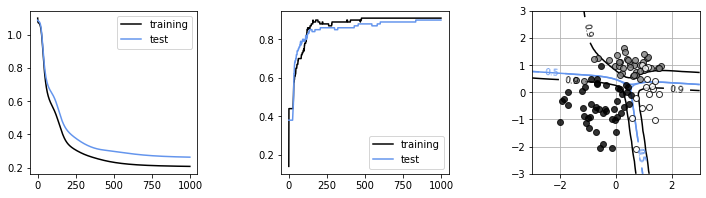

In [24]:
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace = 0.5)

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label = 'training')
plt.plot(history.history['val_loss'], 'cornflowerblue', label = 'test')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label = 'training')
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='test')
plt.legend()

plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)

xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn*xn, 'F'), np.reshape(xx1, xn * xn , 'F')]
y = model.predict(x)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels = [0.5, 0.9], colors=[
        'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize = 9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()